https://www.kaggle.com/datasets/seesee/siim-train-test/download

In [1]:
import torch
import os
import cv2

from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import numpy as np
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import torchvision
import config

from importlib import reload
reload(config)


<module 'config' from '/home/ubuntu/unet-tf/project_03/config.py'>

In [3]:
plt.subplots?

Signature:
plt.subplots(
    nrows=1,
    ncols=1,
    *,
    sharex=False,
    sharey=False,
    squeeze=True,
    subplot_kw=None,
    gridspec_kw=None,
    **fig_kw,
)
Docstring:
Create a figure and a set of subplots.

This utility wrapper makes it convenient to create common layouts of
subplots, including the enclosing figure object, in a single call.

Parameters
----------
nrows, ncols : int, default: 1
    Number of rows/columns of the subplot grid.

sharex, sharey : bool or {'none', 'all', 'row', 'col'}, default: False
    Controls sharing of properties among x (*sharex*) or y (*sharey*)
    axes:

    - True or 'all': x- or y-axis will be shared among all subplots.
    - False or 'none': each subplot x- or y-axis will be independent.
    - 'row': each subplot row will share an x- or y-axis.
    - 'col': each subplot column will share an x- or y-axis.

    When subplots have a shared x-axis along a column, only the x tick
    labels of the bottom subplot are created. Similarly, 

In [10]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, mask_paths, transforms):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transforms = transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #BGR->RGB
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        if self.transforms is not None:
            image, mask = self.transforms(image), self.transforms(mask)
        return image, mask

In [11]:
class Block(torch.nn.Module):
    """Conv->ReLU->Conv->ReLU"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, 3)
        self.relu = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, 3)

    def forward(self, x):
        return self.relu(self.conv2(self.relu(self.conv1(x))))


In [12]:
class Encoder(torch.nn.Module):
    def __init__(self, channels=(3, 16, 32, 64)):
        super().__init__()
        self.enc_blocks = torch.nn.ModuleList(
            [Block(channels[i], channels[i + 1]) for i in range(len(channels) - 1)]
        )
        self.pool = torch.nn.MaxPool2d(2)

    def forward(self, x):
        outputs = [] # intermediate outputs
        for block in self.enc_blocks:
            x = block(x)
            outputs.append(x)
            x = self.pool(x)
        return outputs


In [13]:
class Decoder(torch.nn.Module):
    def __init__(self, channels=(64, 32, 16)):
        super().__init__()
        self.channels = channels
        self.upconvs = torch.nn.ModuleList(
            [
                torch.nn.ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
                for i in range(len(channels) - 1)
            ]
        )
        self.dec_blocks = torch.nn.ModuleList(
            [Block(channels[i], channels[i + 1]) for i in range(len(channels) - 1)]
        )
        
    def forward(self, enc_output):
        x = enc_output[-1]
        for enc, dec, up in zip(enc_output[::-1][1:], self.dec_blocks, self.upconvs):
            x_up = up(x)
            x = dec(torch.cat([x_up, self.crop(enc, x_up)], dim=1))
        return x
    
    @staticmethod
    def crop(enc_features, x):
        (_, _, h, w) = x.shape
        return torchvision.transforms.CenterCrop([h, w])(enc_features)


In [14]:
class UNet(torch.nn.Module):
    def __init__(
        self, 
        enc_channels=(3, 16, 32, 64),
        dec_channels=(64, 32, 16),
        nb_classes=1, retain_dim=True,
        out_size=(config.INPUT_IMAGE_HEIGHT,  config.INPUT_IMAGE_WIDTH)
    ):
        super().__init__()
        self.encoder = Encoder(enc_channels)
        self.decoder = Decoder(dec_channels)
        self.head = torch.nn.Conv2d(
            in_channels=dec_channels[-1],
            out_channels=nb_classes,
            kernel_size=1,
        )
        self.retain_dim = retain_dim
        self.out_size = out_size

    def forward(self, x):
        enc_output = self.encoder(x)
        dec_output = self.decoder(enc_output)
        segm_map = self.head(dec_output)
        if self.retain_dim:
            segm_map = torch.nn.functional.interpolate(segm_map, self.out_size)
        return segm_map
    

# Data preparation

In [8]:
# image_paths[0]

In [9]:
from sklearn.model_selection import train_test_split

image_paths = sorted(list(paths.list_images(config.IMAGE_DATASET_PATH)))
mask_paths = sorted(list(paths.list_images(config.MASK_DATASET_PATH)))
train_images, test_images, train_masks, test_masks = train_test_split(
    image_paths, mask_paths, test_size=config.TEST_SPLIT, random_state=1337
)
print("[INFO] saving testing image paths...")
with open(config.TEST_PATHS, "w") as fp:
    fp.write("\n".join(test_images))


[INFO] saving testing image paths...


In [8]:
import torchvision

transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.Resize((config.INPUT_IMAGE_HEIGHT, config.INPUT_IMAGE_WIDTH)),
        torchvision.transforms.ToTensor()
    ]
)
train_ds = Dataset(image_paths=train_images, mask_paths=train_masks, transforms=transforms)
test_ds = Dataset(image_paths=test_images, mask_paths=test_masks, transforms=transforms)
print(f"[INFO] found {len(train_ds)} examples in the training set...")
print(f"[INFO] found {len(test_ds)} examples in the test set...")
train_loader = torch.utils.data.DataLoader(
    train_ds, 
    shuffle=True,
    batch_size=config.BATCH_SIZE, 
    pin_memory=config.PIN_MEMORY,
    num_workers=os.cpu_count()
)
test_loader = torch.utils.data.DataLoader(
    test_ds, 
    shuffle=False,
    batch_size=config.BATCH_SIZE, 
    pin_memory=config.PIN_MEMORY,
    num_workers=os.cpu_count()
)

[INFO] found 3400 examples in the training set...
[INFO] found 600 examples in the test set...


In [10]:
unet = UNet().to(config.DEVICE)
loss_fn = torch.nn.BCEWithLogitsLoss()
opt = torch.optim.Adam(unet.parameters(), lr=config.INIT_LR)
train_steps = len(train_ds) // config.BATCH_SIZE
test_steps = len(test_ds) // config.BATCH_SIZE
H = {"train_loss": [], "test_loss": []}

In [17]:
if os.path.exists(config.PATH_MODEL):
    checkpoint = torch.load(config.PATH_MODEL)
    unet.load_state_dict(checkpoint['model_state_dict'])
    opt.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
print("[INFO] training the network...")
start_time = time.time()
for e in tqdm(range(config.NUM_EPOCHS)):
    unet.train()
    # initialize the total training and validation loss
    total_train_loss = 0
    total_test_loss = 0
    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(config.DEVICE), y.to(config.DEVICE)
        loss = loss_fn(unet(x), y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_train_loss += loss
    with torch.no_grad():
        unet.eval()
        for x, y in test_loader:
            x, y = x.to(config.DEVICE), y.to(config.DEVICE)
            total_test_loss += loss_fn(unet(x), y)
    avg_train_loss = total_train_loss / train_steps
    avg_test_loss = total_test_loss / test_steps
    torch.save(
        {
            "epoch": i,
            "model_state_dict": unet.state_dict(),
            "optimizer_state_dict": opt.state_dict(),
            "avg_train_loss": avg_train_loss,
            "avg_test_loss": avg_test_loss,
        }, 
        config.PATH_MODEL
    )
    H["train_loss"].append(avg_train_loss.cpu().detach().numpy())
    H["test_loss"].append(avg_test_loss.cpu().detach().numpy())
    print(f"[INFO] EPOCH: {e + 1}/{config.NUM_EPOCHS}")
    print(f"Train loss: {avg_train_loss:.6f}, Test loss: {avg_test_loss:.4f}")
print(f"[INFO] total time taken to train the model: {time.time() - start_time:.2f}s")


[INFO] training the network...


  2%|█                                           | 1/40 [00:35<23:02, 35.45s/it]

[INFO] EPOCH: 1/40
Train loss: 0.548802, Test loss: 0.5379


  5%|██▏                                         | 2/40 [01:12<23:12, 36.64s/it]

[INFO] EPOCH: 2/40
Train loss: 0.563251, Test loss: 0.6037


  8%|███▎                                        | 3/40 [01:48<22:22, 36.28s/it]

[INFO] EPOCH: 3/40
Train loss: 0.544722, Test loss: 0.5521


 10%|████▍                                       | 4/40 [02:27<22:14, 37.06s/it]

[INFO] EPOCH: 4/40
Train loss: 0.501175, Test loss: 0.5104


 12%|█████▌                                      | 5/40 [03:05<21:53, 37.52s/it]

[INFO] EPOCH: 5/40
Train loss: 0.479453, Test loss: 0.4747


 15%|██████▌                                     | 6/40 [03:42<21:09, 37.34s/it]

[INFO] EPOCH: 6/40
Train loss: 0.447504, Test loss: 0.4173


 18%|███████▋                                    | 7/40 [04:19<20:31, 37.31s/it]

[INFO] EPOCH: 7/40
Train loss: 0.449059, Test loss: 0.4728


 20%|████████▊                                   | 8/40 [04:56<19:46, 37.07s/it]

[INFO] EPOCH: 8/40
Train loss: 0.418418, Test loss: 0.4010


 22%|█████████▉                                  | 9/40 [05:29<18:30, 35.81s/it]

[INFO] EPOCH: 9/40
Train loss: 0.399978, Test loss: 0.4259


 25%|██████████▊                                | 10/40 [06:07<18:18, 36.62s/it]

[INFO] EPOCH: 10/40
Train loss: 0.391430, Test loss: 0.3843


 28%|███████████▊                               | 11/40 [06:45<17:48, 36.85s/it]

[INFO] EPOCH: 11/40
Train loss: 0.385200, Test loss: 0.3672


 30%|████████████▉                              | 12/40 [07:23<17:23, 37.27s/it]

[INFO] EPOCH: 12/40
Train loss: 0.378320, Test loss: 0.3723


 32%|█████████████▉                             | 13/40 [08:00<16:43, 37.18s/it]

[INFO] EPOCH: 13/40
Train loss: 0.366386, Test loss: 0.3588


 35%|███████████████                            | 14/40 [08:36<15:56, 36.78s/it]

[INFO] EPOCH: 14/40
Train loss: 0.372013, Test loss: 0.3597


 38%|████████████████▏                          | 15/40 [09:14<15:34, 37.37s/it]

[INFO] EPOCH: 15/40
Train loss: 0.366995, Test loss: 0.3432


 40%|█████████████████▏                         | 16/40 [09:49<14:38, 36.59s/it]

[INFO] EPOCH: 16/40
Train loss: 0.352385, Test loss: 0.3487


 42%|██████████████████▎                        | 17/40 [10:26<14:06, 36.81s/it]

[INFO] EPOCH: 17/40
Train loss: 0.362817, Test loss: 0.3583


 45%|███████████████████▎                       | 18/40 [11:04<13:35, 37.06s/it]

[INFO] EPOCH: 18/40
Train loss: 0.346585, Test loss: 0.3549


 48%|████████████████████▍                      | 19/40 [11:42<13:02, 37.24s/it]

[INFO] EPOCH: 19/40
Train loss: 0.354373, Test loss: 0.3544


 50%|█████████████████████▌                     | 20/40 [12:18<12:20, 37.00s/it]

[INFO] EPOCH: 20/40
Train loss: 0.338445, Test loss: 0.3348


 52%|██████████████████████▌                    | 21/40 [12:55<11:40, 36.85s/it]

[INFO] EPOCH: 21/40
Train loss: 0.343269, Test loss: 0.3338


 55%|███████████████████████▋                   | 22/40 [13:33<11:09, 37.20s/it]

[INFO] EPOCH: 22/40
Train loss: 0.340373, Test loss: 0.3701


 57%|████████████████████████▋                  | 23/40 [14:11<10:36, 37.45s/it]

[INFO] EPOCH: 23/40
Train loss: 0.342626, Test loss: 0.3259


 60%|█████████████████████████▊                 | 24/40 [14:49<10:02, 37.68s/it]

[INFO] EPOCH: 24/40
Train loss: 0.342659, Test loss: 0.3274


 62%|██████████████████████████▉                | 25/40 [15:28<09:30, 38.03s/it]

[INFO] EPOCH: 25/40
Train loss: 0.328600, Test loss: 0.3328


 65%|███████████████████████████▉               | 26/40 [16:05<08:49, 37.82s/it]

[INFO] EPOCH: 26/40
Train loss: 0.326265, Test loss: 0.3199


 68%|█████████████████████████████              | 27/40 [16:41<08:04, 37.29s/it]

[INFO] EPOCH: 27/40
Train loss: 0.327705, Test loss: 0.3365


 70%|██████████████████████████████             | 28/40 [17:18<07:26, 37.23s/it]

[INFO] EPOCH: 28/40
Train loss: 0.336390, Test loss: 0.3282


 72%|███████████████████████████████▏           | 29/40 [17:52<06:39, 36.28s/it]

[INFO] EPOCH: 29/40
Train loss: 0.322900, Test loss: 0.3160


 75%|████████████████████████████████▎          | 30/40 [18:28<05:59, 35.99s/it]

[INFO] EPOCH: 30/40
Train loss: 0.327867, Test loss: 0.3168


 78%|█████████████████████████████████▎         | 31/40 [19:06<05:30, 36.73s/it]

[INFO] EPOCH: 31/40
Train loss: 0.318005, Test loss: 0.3209


 80%|██████████████████████████████████▍        | 32/40 [19:42<04:50, 36.35s/it]

[INFO] EPOCH: 32/40
Train loss: 0.322391, Test loss: 0.3101


 82%|███████████████████████████████████▍       | 33/40 [20:19<04:16, 36.64s/it]

[INFO] EPOCH: 33/40
Train loss: 0.310374, Test loss: 0.3004


 85%|████████████████████████████████████▌      | 34/40 [20:53<03:36, 36.01s/it]

[INFO] EPOCH: 34/40
Train loss: 0.313127, Test loss: 0.3124


 88%|█████████████████████████████████████▋     | 35/40 [21:28<02:58, 35.67s/it]

[INFO] EPOCH: 35/40
Train loss: 0.304381, Test loss: 0.3143


 90%|██████████████████████████████████████▋    | 36/40 [22:06<02:24, 36.23s/it]

[INFO] EPOCH: 36/40
Train loss: 0.309130, Test loss: 0.3093


 92%|███████████████████████████████████████▊   | 37/40 [22:42<01:48, 36.18s/it]

[INFO] EPOCH: 37/40
Train loss: 0.302764, Test loss: 0.3074


 95%|████████████████████████████████████████▊  | 38/40 [23:18<01:12, 36.15s/it]

[INFO] EPOCH: 38/40
Train loss: 0.291651, Test loss: 0.2934


 98%|█████████████████████████████████████████▉ | 39/40 [23:53<00:35, 35.87s/it]

[INFO] EPOCH: 39/40
Train loss: 0.288864, Test loss: 0.2949


100%|███████████████████████████████████████████| 40/40 [24:32<00:00, 36.80s/it]

[INFO] EPOCH: 40/40
Train loss: 0.282455, Test loss: 0.2832
[INFO] total time taken to train the model: 1472.17s


In [15]:
def prepare_image(image):
    transforms = torchvision.transforms.Compose(
        [
            torchvision.transforms.ToPILImage(),
            torchvision.transforms.Resize((config.INPUT_IMAGE_HEIGHT, config.INPUT_IMAGE_WIDTH)),
            torchvision.transforms.ToTensor()
        ]
    )
    # image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #BGR->RGB
    if transforms is not None:
        image = transforms(image)
    return image


In [45]:
# nparr = np.fromstring(img_str, np.uint8)
# img_np = cv2.imdecode(nparr, cv2.CV_LOAD_IMAGE_COLOR)

# img = load_image(
#     '/home/ubuntu/tgs-salt-identification-challenge/train/images/000e218f21.png'
# )


In [35]:
# if os.path.exists(config.PATH_MODEL):
#     unet = UNet().to(config.DEVICE)
# loss_fn = torch.nn.BCEWithLogitsLoss()
# opt = torch.optim.Adam(unet.parameters(), lr=config.INIT_LR)
#     checkpoint = torch.load(config.PATH_MODEL)
#     unet.load_state_dict(checkpoint['model_state_dict'])
#     opt.load_state_dict(checkpoint['optimizer_state_dict'])
#     return unet


In [17]:
def load_model(path):
    unet = UNet().to(config.DEVICE)
    loss_fn = torch.nn.BCEWithLogitsLoss()
    opt = torch.optim.Adam(unet.parameters(), lr=config.INIT_LR)
    checkpoint = torch.load(path)
    unet.load_state_dict(checkpoint['model_state_dict'])
    unet.eval()
    return unet


In [18]:
image_raw = cv2.imread(
    '/home/ubuntu/tgs-salt-identification-challenge/train/images/000e218f21.png'
)
image = prepare_image(image_raw)
model = load_model(config.PATH_MODEL)


In [20]:
pred = model(image.unsqueeze(0))

In [21]:
def prepare_plot(origImage, origMask, predMask):
    # initialize our figure
    figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    # plot the original image, its mask, and the predicted mask
    ax[0].imshow(origImage)
    ax[1].imshow(origMask)
    ax[2].imshow(predMask)
    # set the titles of the subplots
    ax[0].set_title("Image")
    ax[1].set_title("Original Mask")
    ax[2].set_title("Predicted Mask")
    # set the layout of the figure and display it
    figure.tight_layout()
    figure.show()

def make_predictions(model, imagePath):
    # set model to evaluation mode
    model.eval()
    # turn off gradient tracking
    with torch.no_grad():
        # load the image from disk, swap its color channels, cast it
        # to float data type, and scale its pixel values
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype("float32") / 255.0
        # resize the image and make a copy of it for visualization
        image = cv2.resize(image, (128, 128))
        orig = image.copy()
        # find the filename and generate the path to ground truth
        # mask
        filename = imagePath.split(os.path.sep)[-1]
        groundTruthPath = os.path.join(config.MASK_DATASET_PATH,
            filename)
        # load the ground-truth segmentation mask in grayscale mode
        # and resize it
        gtMask = cv2.imread(groundTruthPath, 0)
        gtMask = cv2.resize(gtMask, (config.INPUT_IMAGE_HEIGHT,
            config.INPUT_IMAGE_HEIGHT))
        # make the channel axis to be the leading one, add a batch
        # dimension, create a PyTorch tensor, and flash it to the
        # current device
        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image).to(config.DEVICE)
        # make the prediction, pass the results through the sigmoid
        # function, and convert the result to a NumPy array
        predMask = model(image).squeeze()
        predMask = torch.sigmoid(predMask)
        predMask = predMask.cpu().numpy()
        # filter out the weak predictions and convert them to integers
        predMask = (predMask > config.THRESHOLD) * 255
        predMask = predMask.astype(np.uint8)
        # prepare a plot for visualization
        prepare_plot(orig, gtMask, predMask)

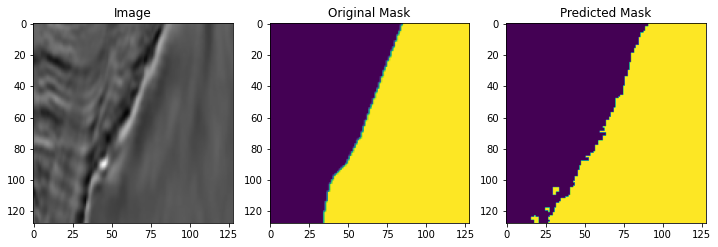

In [22]:
make_predictions(model, image_paths[5])

In [23]:
def make_predictions(model, imagePath):
    # set model to evaluation mode
    model.eval()
    # turn off gradient tracking
    with torch.no_grad():
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        orig = image.copy()
        image = image.astype("float32") / 255.0
        image = cv2.resize(image, (128, 128))
        # orig = image.copy()
        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image).to(config.DEVICE)
        # make the prediction, pass the results through the sigmoid
        # function, and convert the result to a NumPy array
        predMask = model(image).squeeze()
        predMask = torch.sigmoid(predMask)
        predMask = predMask.cpu()#.numpy()
        # filter out the weak predictions and convert them to integers
        predMask = (predMask > config.THRESHOLD) * 255
        predMask = predMask.to(torch.bool)#astype(np.uint8)
        # prepare a plot for visualization
        # prepare_plot(orig, gtMask, predMask)
        # img_mask = draw_segmentation_masks(
        #     image=image.to(torch.uint8).squeeze(),
        #     masks=predMask.squeeze(),
        #     alpha=0.5
        # )
        # return img_mask
        return orig, image,  predMask


In [24]:
# res = make_predictions(model, image_paths[5])
# cv2.imwrite(filename="res.png", img=res.permute(1,2,0).numpy())
# (torch.from_numpy(img_orig).to(config.DEVICE) * 255).to(torch.uint8)
# torch.from_numpy(img_orig)

In [26]:
# cv2.resize(img_orig, (128, 128)).transpose(2, 0, 1).shape

In [27]:
# cv2.resize(img_orig, (128, 128))#convert?#("RGB")

In [43]:
import cv2
import torch
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.transforms.functional import to_tensor
from matplotlib import pyplot as plt
from copy import deepcopy


class Visualizer:
    @staticmethod
    def add_boxes(img, boxes):        
        img_bbox = draw_bounding_boxes(
            image=img,
            boxes=boxes
        )
        return img_bbox

    @staticmethod
    def add_masks(img, masks):
        img_mask = draw_segmentation_masks(
            image=img,
            masks=masks,
            alpha=0.9,
            colors="yellow"
        )
        return img_mask

    @classmethod
    def save(cls, img, filepath, boxes=None, masks=None):
        img = (deepcopy(img) * 255).to(torch.uint8)
        if boxes is not None: img = cls.add_boxes(img, boxes)
        if masks is not None: img = cls.add_masks(img, masks)
        img_save = cv2.cvtColor(
            img.permute(1,2,0).numpy(),
            cv2.COLOR_RGB2BGR
        )
        cv2.imwrite(filename=filepath, img=img_save)

    @classmethod
    def show(cls, img, boxes=None, masks=None):
        img = (deepcopy(img) * 255).to(torch.uint8)
        if boxes is not None: img = cls.add_boxes(img, boxes)
        if masks is not None: img = cls.add_masks(img, masks)
        plt.figure(figsize = (10,10))
        plt.imshow(img.permute(1,2,0))




In [44]:
img_orig, img_res, mask = make_predictions(model, image_paths[5])
# Visualizer.show(
#     img=torch.from_numpy(cv2.resize(img_orig, (128, 128)).transpose(2, 0, 1)), 
#     masks=mask#.to(torch.uint8)
# )
Visualizer.save(
    filepath="result.png",
    img=torch.from_numpy(cv2.resize(img_orig, (128, 128)).transpose(2, 0, 1)), 
    masks=mask#.to(torch.uint8)
)

In [46]:
image_paths[5]

'/home/ubuntu/tgs-salt-identification-challenge/train/images/0061281eea.png'

In [ ]:
img = (deepcopy(img) * 255).to(torch.uint8)
if boxes is not None: img = cls.add_boxes(img, boxes)
if masks is not None: img = cls.add_masks(img, masks)
plt.figure(figsize = (10,10))
plt.imshow(img.permute(1,2,0))